In [ ]:
### TODO, short term (by 11.11)
### Fix math error happpening in title of the output graphic

### TODO, medium term (by 11.25)
### Develop test using Codex thaat makes sure that calculations are correct

### TODO, long term (12.09)
### Develop method for testing NAM3K against RTMA

from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [15]:
date = input("Enter date (YYYY-MM-DD): ")
inithour = input("Enter initialization hour (HH):00 ")
init = inithour.strip(":00")
forecast = input("Enter forecast hour in 24-hour time (HH)")
displayhour = 0
if int(forecast) + int(init) > 23:
    displayhour = int(forecast) + int(init) - 24
else:
    displayhour = int(forecast) + int(init)
hrrr = Herbie(
    str(date + " " + init), 
    model="hrrr", 
    product="sfc", 
    fxx=int(forecast)
)

rtma = Herbie(
    str(date + " " + forecast + ":00"), 
    model="rtma", 
    product="anl"
)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Nov-05 12:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=rtma ┊ product=anl ┊ 2025-Nov-05 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [16]:
ds_hrrr = hrrr.xarray("TMP:2 m above")
ds_hrrr

<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-11-05T12:00:00
    step                 timedelta64[ns] 8B 18:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-11-06T06:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 295.1 295.1 295.1 ... 280.2 280.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/john_b_needham/data/hrrr/20251105/subset_...
    search:                  TMP:2 m above

In [17]:
ds_rtma = rtma.xarray("TMP:2 m above")
ds_rtma

<xarray.Dataset> Size: 75MB
Dimensions:              (y: 1597, x: 2345)
Coordinates:
    time                 datetime64[ns] 8B 2025-11-05T18:00:00
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 30MB 19.23 19.23 19.24 ... 54.38 54.37
    longitude            (y, x) float64 30MB 233.7 233.7 233.8 ... 300.9 301.0
    valid_time           datetime64[ns] 8B 2025-11-05T18:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 15MB 296.4 296.4 296.4 ... 273.2 272.9
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   rtma
    product:                 anl
    description:             CONUS Real-Time Mesoscale Analysis (RTMA)
    remote_grib:             https://noaa-rtma-pds.s3.amazonaws.com/rtma2p5.2...
    local_grib:              /Users/john_b_needham/data/rtma/20251105/subset_...
    search:                  TMP:2 m above

In [18]:
ds_rtma = ds_rtma.assign_coords(x=ds_rtma.x, y=ds_rtma.y)
ds_hrrr = ds_hrrr.assign_coords(x=ds_hrrr.x, y=ds_hrrr.y)

rtma_on_hrrr = ds_rtma.interp_like(ds_hrrr)
###tempdiff = rtma_on_hrrr.t2m - ds_hrrr.t2m

In [19]:
# 2) ensure dims align (y,x)
###tempdiff = tempdiff.transpose("y", "x")

In [20]:
rtma_on_hrrr.sizes["x"] == ds_hrrr.sizes["x"]  # -> 1799

True

In [21]:
rtma_on_hrrr.sizes["y"] == ds_hrrr.sizes["y"]  # -> 1059

True

In [22]:
rtma_on_hrrr = rtma_on_hrrr.assign_coords(
    latitude=ds_hrrr.latitude,
    longitude=ds_hrrr.longitude,
)

In [23]:
rtma_on_hrrr["latitude"] == ds_hrrr["latitude"]  # -> True

<xarray.DataArray 'latitude' (y: 1059, x: 1799)> Size: 2MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
    time                 datetime64[ns] 8B 2025-11-05T12:00:00
    step                 timedelta64[ns] 8B 18:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-11-06T06:00:00
    gribfile_projection  object 8B None
  * y                    (y) int64 8kB 0 1 2 3 4 5 ... 1054 1055 1056 1057 1058
  * x                    (x) int64 14kB 0 1 2 3 4 5 ... 1794 1795 1796 1797 1798

In [24]:
rtma_on_hrrr["longitude"] == ds_hrrr["longitude"]  #-> True

<xarray.DataArray 'longitude' (y: 1059, x: 1799)> Size: 2MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
    time                 datetime64[ns] 8B 2025-11-05T12:00:00
    step                 timedelta64[ns] 8B 18:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-11-06T06:00:00
    gribfile_projection  object 8B None
  * y                    (y) int64 8kB 0 1 2 3 4 5 ... 1054 1055 1056 1057 1058
  * x                    (x) int64 14kB 0 1 2 3 4 5 ... 1794 1795 1796 1797 1798

In [25]:
print(ds_hrrr.x.attrs.get("units"), ds_hrrr.y.attrs.get("units"))
print(ds_rtma.herbie.crs)

None None
+proj=lcc +ellps=sphere +a=6371200.0 +b=6371200.0 +lon_0=265.0 +lat_0=25.0 +x_0=0.0 +y_0=0.0 +lat_1=25.0 +lat_2=25.0 +no_defs +type=crs


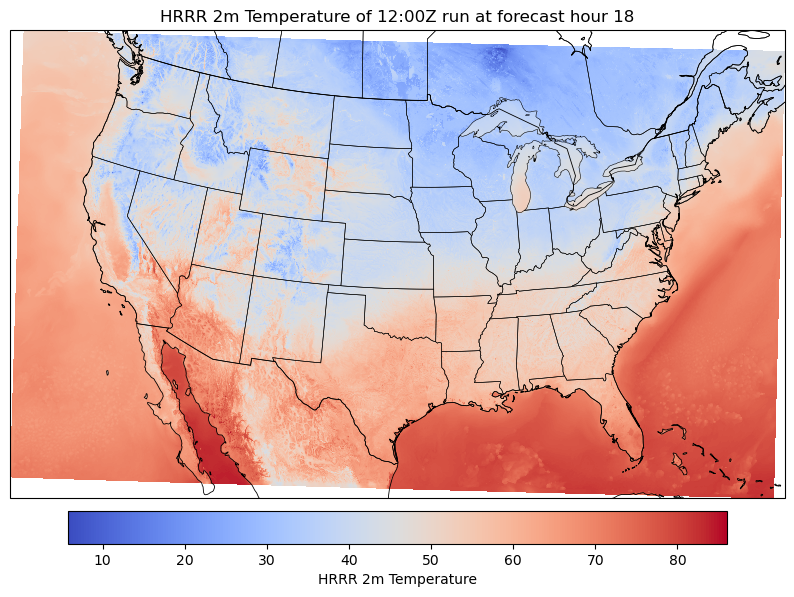

In [26]:
# 2) Use HRRR lon/lat + wrap
lon = ds_hrrr["longitude"]
lat = ds_hrrr["latitude"]
lon = xr.where(lon > 180, lon - 360, lon)

# 3) Make a Cartopy map (no EasyMap)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95))  # pick your map proj
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.coastlines(resolution="50m", linewidth=0.6)

hrrr_f = (ds_hrrr.t2m - 273.15) * 9/5 + 32

# 4) Plot (coordinates are lon/lat centers)
pc = ccrs.PlateCarree()
p = ax.pcolormesh(
    lon, lat, hrrr_f,
    cmap="coolwarm",
    transform=pc,         # data coords
    shading="nearest",     # treat lon/lat as cell centers
)

cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.02, shrink=0.85)
cb.set_label("HRRR 2m Temperature")
ax.set_title("HRRR 2m Temperature of " + str(inithour) + "Z run at forecast hour " + str(forecast))
plt.show()

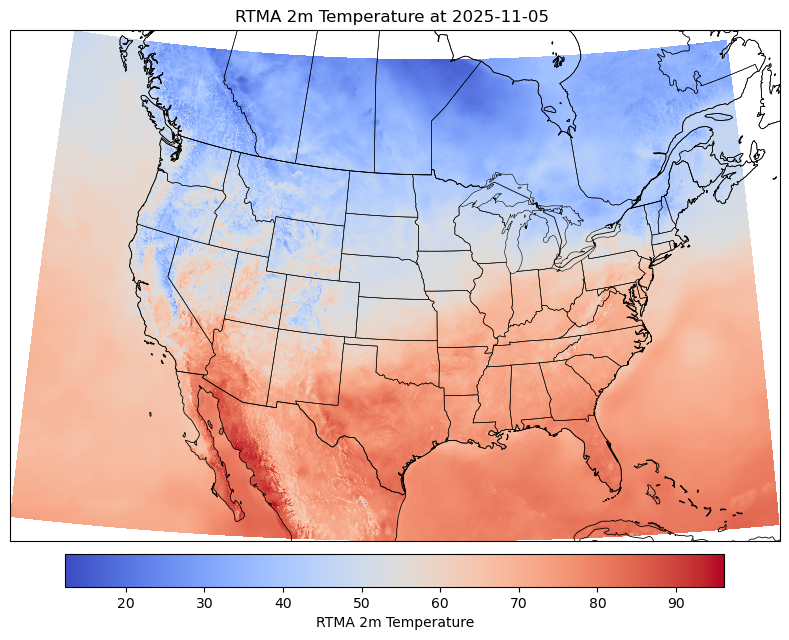

In [27]:
# 2) Use HRRR lon/lat + wrap
lon = ds_rtma["longitude"]
lat = ds_rtma["latitude"]
lon = xr.where(lon > 180, lon - 360, lon)

# 3) Make a Cartopy map (no EasyMap)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95))  # pick your map proj
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.coastlines(resolution="50m", linewidth=0.6)

rtma_f = (ds_rtma.t2m - 273.15) * 9/5 + 32

# 4) Plot (coordinates are lon/lat centers)
pc = ccrs.PlateCarree()
p = ax.pcolormesh(
    lon, lat, rtma_f,
    cmap="coolwarm",
    transform=pc,         # data coords
    shading="nearest",     # treat lon/lat as cell centers
)

cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.02, shrink=0.85)
cb.set_label("RTMA 2m Temperature")
ax.set_title("RTMA 2m Temperature at " + str(date) + " ")
plt.show()

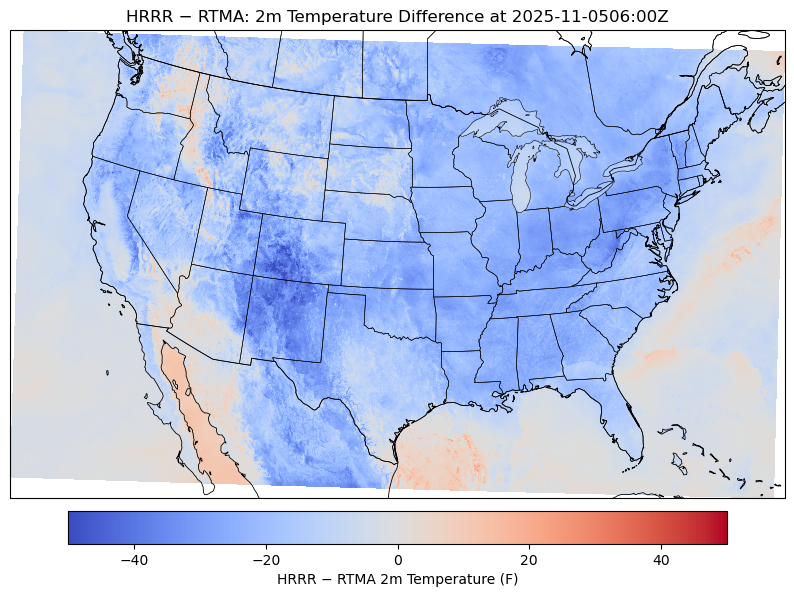

In [28]:
# Compute HRRR - RTMA difference in Fahrenheit
tempdiff = (ds_hrrr.t2m - rtma_on_hrrr.t2m)
tempdiff_f = tempdiff * 9/5

# 2) Use HRRR lon/lat + wrap
lon = ds_hrrr["longitude"]
lat = ds_hrrr["latitude"]
lon = xr.where(lon > 180, lon - 360, lon)

# 3) Make a Cartopy map (no EasyMap)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95))  # pick your map proj
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.coastlines(resolution="50m", linewidth=0.6)

# 4) Plot (coordinates are lon/lat centers)
pc = ccrs.PlateCarree()
p = ax.pcolormesh(
    lon, lat, tempdiff_f,
    cmap="coolwarm",
    transform=pc,         # data coords
    shading="nearest",     # treat lon/lat as cell centers
    vmin=-50, vmax=50
)

cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.02, shrink=0.85)
cb.set_label("HRRR − RTMA 2m Temperature (F)")
ax.set_title("HRRR − RTMA: 2m Temperature Difference at " + str(date) + str(displayhour).zfill(2) + ":00Z")
plt.show()